In [ ]:
from nb_zero_utils import *

### Configure Spark Runtime

In [ ]:
spark = configure_env()

Installing Java 8...
Java 8 Installed.
Installing pyspark and spark-nlp...
pyspark and spark-nlp installed.
Meta data extracted
Starting Spark runtime...
Spark NLP version:  2.4.2
Apache Spark version:  2.4.4
Spark is running.


### Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import pyspark.sql.functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *

from guess_language import guess_language

### Import Data

In [ ]:
meta = spark.read\
                .option("header", "true")\
                .csv("/content/metadata.csv")

In [ ]:
meta.printSchema()

root
 |-- cord_uid: string (nullable = true)
 |-- sha: string (nullable = true)
 |-- source_x: string (nullable = true)
 |-- title: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- pmcid: string (nullable = true)
 |-- pubmed_id: string (nullable = true)
 |-- license: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- mag_id: string (nullable = true)
 |-- who_covidence_id: string (nullable = true)
 |-- arxiv_id: string (nullable = true)
 |-- pdf_json_files: string (nullable = true)
 |-- pmc_json_files: string (nullable = true)
 |-- url: string (nullable = true)
 |-- s2_id: string (nullable = true)



In [ ]:
extra_fields = [
                'sha',
                'doi', 
                'pmcid', 
                'pubmed_id', 
                "mag_id", 
                "who_covidence_id", 
                "arxiv_id", 
                "pdf_json_files", 
                "pmc_json_files", 
                "s2_id"]

meta = meta.drop(*extra_fields)

In [ ]:
meta.printSchema()

root
 |-- cord_uid: string (nullable = true)
 |-- source_x: string (nullable = true)
 |-- title: string (nullable = true)
 |-- license: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- url: string (nullable = true)



In [ ]:
meta.show(5)

+--------+--------+--------------------+-------+--------------------+------------+--------------------+--------------+--------------------+
|cord_uid|source_x|               title|license|            abstract|publish_time|             authors|       journal|                 url|
+--------+--------+--------------------+-------+--------------------+------------+--------------------+--------------+--------------------+
|ug7v899j|     PMC|Clinical features...|  no-cc|OBJECTIVE: This r...|  2001-07-04|Madani, Tariq A; ...|BMC Infect Dis|https://www.ncbi....|
|02tnwd4m|     PMC|Nitric oxide: a p...|  no-cc|Inflammatory dise...|  2000-08-15|Vliet, Albert van...|    Respir Res|https://www.ncbi....|
|ejv2xln0|     PMC|Surfactant protei...|  no-cc|Surfactant protei...|  2000-08-25|     Crouch, Erika C|    Respir Res|https://www.ncbi....|
|2b73a28n|     PMC|Role of endotheli...|  no-cc|Endothelin-1 (ET-...|  2001-02-22|Fagan, Karen A; M...|    Respir Res|https://www.ncbi....|
|9785vg6d|     PMC|G

### Date

In [ ]:
meta.filter(F.length("publish_time") != 10).sample(True, .2, 20).show(5)

+--------+--------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|cord_uid|source_x|               title|license|            abstract|        publish_time|             authors|             journal|                 url|
+--------+--------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|s64v656n|     PMC|Injection drug us...|  cc-by|"Illicit drug abu...| China has also b...| and many share n...| which conflict w...|                null|
|fj9l8che|     PMC|The evolution of ...|  cc-by|"BACKGROUND: Know...| especially with ...| polymerase acidi...| matrix protein 1...|             Virol J|
|0ybn2igj|     PMC|"Initial psycholo...|  cc-by|"BACKGROUND: The ...| and regional dif...| purchase of prep...| perceived risk g...| p < .001). 36% r...|
|uvv06b4n|     PMC|Noninvasive venti...|  cc-by|                null|       

In [ ]:
dated_by_year = meta.filter(F.length(meta.publish_time) == 4).withColumnRenamed("publish_time", "publish_year")
dated_by_year = dated_by_year.withColumn("publish_year", F.year(dated_by_year["publish_year"].cast(DateType())))

In [ ]:
meta = meta.filter(F.length("publish_time") == 10)
meta = meta.withColumn('publish_time', F.year(meta["publish_time"].cast(DateType())))
meta = meta.filter((F.length(meta.publish_time) == 4))

In [ ]:
meta.cache()
print(f"Number of records: {meta.count()}")
meta = meta.withColumnRenamed("publish_time", "publish_year")
meta.select("title", "publish_year").show(5)

Number of records: 111330
+--------------------+------------+
|               title|publish_year|
+--------------------+------------+
|Clinical features...|        2001|
|Nitric oxide: a p...|        2000|
|Surfactant protei...|        2000|
|Role of endotheli...|        2001|
|Gene expression i...|        2001|
+--------------------+------------+
only showing top 5 rows



In [ ]:
meta = meta.union(dated_by_year)
meta = meta.filter(meta.publish_year.isNotNull()) 

In [ ]:
meta.cache()
print(f"Number of records: {meta.count()}")
meta.show()

Number of records: 200364
+--------+--------+--------------------+---------+--------------------+------------+--------------------+--------------------+--------------------+
|cord_uid|source_x|               title|  license|            abstract|publish_year|             authors|             journal|                 url|
+--------+--------+--------------------+---------+--------------------+------------+--------------------+--------------------+--------------------+
|ug7v899j|     PMC|Clinical features...|    no-cc|OBJECTIVE: This r...|        2001|Madani, Tariq A; ...|      BMC Infect Dis|https://www.ncbi....|
|02tnwd4m|     PMC|Nitric oxide: a p...|    no-cc|Inflammatory dise...|        2000|Vliet, Albert van...|          Respir Res|https://www.ncbi....|
|ejv2xln0|     PMC|Surfactant protei...|    no-cc|Surfactant protei...|        2000|     Crouch, Erika C|          Respir Res|https://www.ncbi....|
|2b73a28n|     PMC|Role of endotheli...|    no-cc|Endothelin-1 (ET-...|        2001|Fa

Record Count:  200364


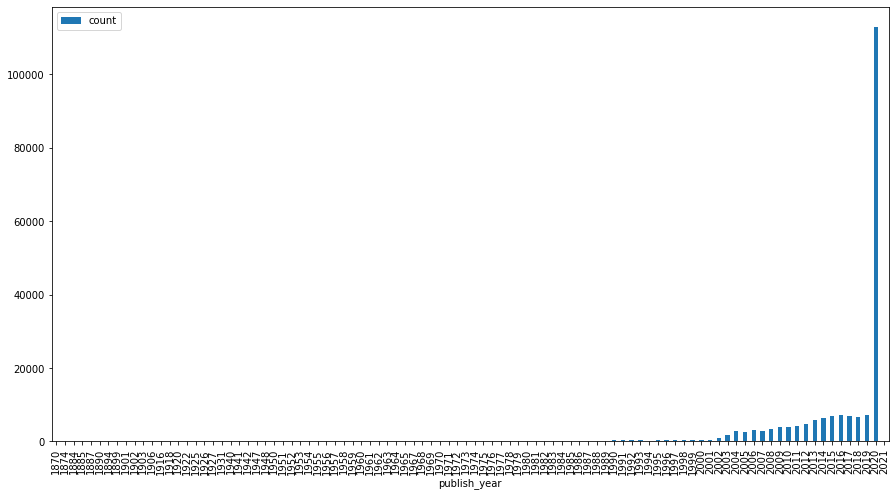

In [ ]:
meta = meta.filter(meta.publish_year.isNotNull())
meta.cache()
print("Record Count: ", meta.count())
meta.groupBy("publish_year").count().select("publish_year", "count").toPandas() \
.set_index("publish_year").sort_index( ascending=True,).plot.bar(figsize=(15,8))

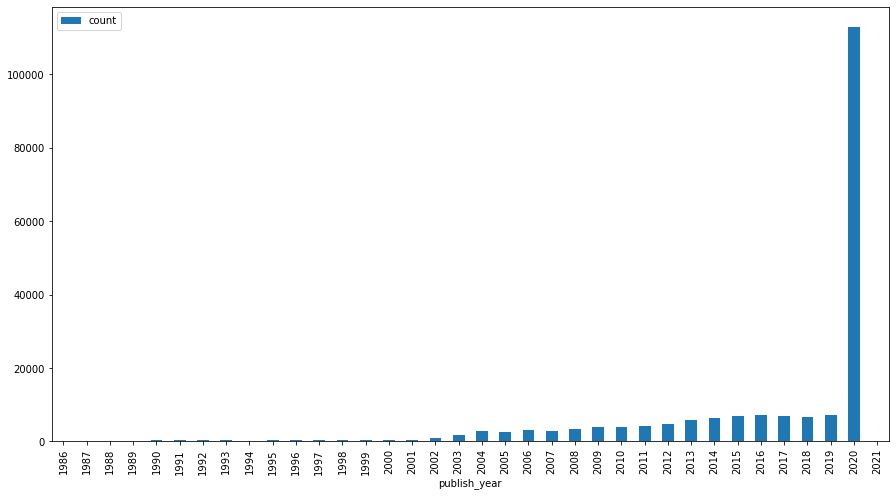

In [ ]:
test = meta.filter(meta.publish_year > 1985)
test.groupBy("publish_year").count().select("publish_year", "count").toPandas() \
.set_index("publish_year").sort_index( ascending=True,).plot.bar(figsize=(15,8))

### Unique Constraint 

In [ ]:
meta = de_duplicate_df(meta, ['abstract', 'title', 'cord_uid'])

There are 71407 duplicate values in column abstract
Cleaning...
Done.
There are now 0 duplicate values in column abstract
There are 5228 duplicate values in column title
Cleaning...
Done.
There are now 0 duplicate values in column title
There are 256 duplicate values in column cord_uid
Cleaning...
Done.
There are now 0 duplicate values in column cord_uid


In [ ]:
meta.cache()
print("Record Count: ", meta.count())

Record Count:  123473


In [ ]:
udfGetWordCount = udf(get_word_count, IntegerType())
meta = meta.withColumn('word_count', udfGetWordCount('abstract'))

In [ ]:
meta.select('abstract', 'word_count').show(5)

+--------------------+----------+
|            abstract|word_count|
+--------------------+----------+
|Abstract The N-te...|       207|
|Human immunodefic...|       201|
|The effect of hyd...|       236|
|Background To dat...|       259|
|SARS2-CoV-2 break...|       247|
+--------------------+----------+
only showing top 5 rows



In [ ]:
meta.toPandas()['word_count'].describe()

count    120681.000000
mean        197.186334
std         118.211208
min           1.000000
25%         138.000000
50%         197.000000
75%         250.000000
max       18000.000000
Name: word_count, dtype: float64

In [ ]:
#abstracts w/ counts within 25th percentile and 1 std of the mean
meta.filter(meta.word_count < 19).sample(True, .2, 10).show()

In [ ]:
meta = meta.filter((meta.abstract.isNotNull()) &
                   (meta.authors.isNotNull()) &
                   (meta.title.isNotNull()) &
                   (meta.url.isNotNull()))

### Collecting English Abstracts 

In [ ]:
udfGetLang = udf(get_language, StringType())
meta = meta.withColumn("language", udfGetLang("abstract").cast(StringType()))

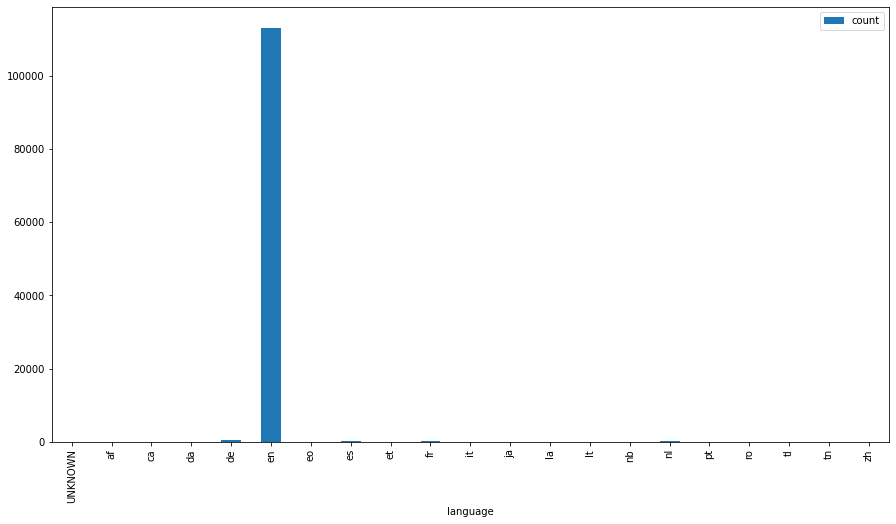

In [ ]:
test = meta
test.groupBy("language").count().select("language", "count").toPandas() \
.set_index("language").sort_index(ascending=True,).plot.bar(figsize=(15,8))

In [ ]:
meta = meta.filter(meta.language == "en").drop("language")
print("Record Count: ", meta.count())

Record Count:  113072


In [ ]:
#abstracts w/ counts within 25th percentile and 1 std of the mean
meta.filter(meta.word_count < 19).select("abstract").show(10, truncate=False)

+-------------------------------------------------------------------------------------------------------------------+
|abstract                                                                                                           |
+-------------------------------------------------------------------------------------------------------------------+
|The majority of healthcare in Canada is universally provided and publicly funded through the provincial government.|
|What will be the role of theragnostic patents in upstream and downstream biomarker research?                       |
|The volume of the isolation ward is not large, so the air distribution is relative simple.                         |
|Sequence shows that animal spawned SARS virus.                                                                     |
|The original version of this article unfortunately contained a mistake.                                            |
|Supplemental Digital Content is available in the text. 

### Removing Non-Asiic Characters 

In [ ]:
meta.cache()
meta.toPandas()['word_count'].describe()

count    113072.000000
mean        197.480110
std         117.431875
min           3.000000
25%         140.000000
50%         197.000000
75%         250.000000
max       18000.000000
Name: word_count, dtype: float64

In [ ]:
udfcheckNonAsiic = udf(is_asiic, BooleanType())
meta = meta.filter((udfcheckNonAsiic(meta["abstract"]) == True) &
                   (meta.word_count > 20))

In [ ]:
meta.toPandas()['word_count'].describe()

count    112187.000000
mean        198.675631
std         116.975241
min          21.000000
25%         141.000000
50%         198.000000
75%         250.000000
max       18000.000000
Name: word_count, dtype: float64

In [ ]:
test = meta.filter(meta.abstract.contains("ELECTRONIC SUPPLEMENTARY MATERIAL"))
test.show(5)

+--------+------------+--------------------+-------+--------------------+------------+--------------------+------------------+--------------------+----------+
|cord_uid|    source_x|               title|license|            abstract|publish_year|             authors|           journal|                 url|word_count|
+--------+------------+--------------------+-------+--------------------+------------+--------------------+------------------+--------------------+----------+
|0pzjyrdf|Medline; PMC|Detection of Alph...|  no-cc|A survey was carr...|        2013|Lima, Francisco E...|       Virus Genes|https://www.ncbi....|       107|
|7o7ofk1e|Medline; PMC|The porcine trans...|  cc-by|BACKGROUND: The u...|        2017|Dawson, Harry D.;...|      BMC Genomics|https://doi.org/1...|       295|
|eszp9jnw|         PMC|Genetic Variation...|  no-cc|Enteroviruses (EV...|        2020|Zhou, Yonghong; V...|         Virol Sin|https://www.ncbi....|       263|
|lq46nj8j|Medline; PMC|Clinical course o...|  

In [ ]:
suffix = "ELECTRONIC SUPPLEMENTARY MATERIAL"
test = meta.withColumn("abstract", F.split(col("abstract"), suffix).getItem(0))
test.filter(test.abstract.contains(suffix)).show()


+--------+--------+-----+-------+--------+------------+-------+-------+---+----------+
|cord_uid|source_x|title|license|abstract|publish_year|authors|journal|url|word_count|
+--------+--------+-----+-------+--------+------------+-------+-------+---+----------+
+--------+--------+-----+-------+--------+------------+-------+-------+---+----------+



In [ ]:
copyright = "This article is protected by copyright. All rights reserved."
meta.filter(meta.abstract.contains(copyright))
meta.show(5)

+--------+--------------------+--------------------+---------+--------------------+------------+--------------------+--------------------+--------------------+----------+
|cord_uid|            source_x|               title|  license|            abstract|publish_year|             authors|             journal|                 url|word_count|
+--------+--------------------+--------------------+---------+--------------------+------------+--------------------+--------------------+--------------------+----------+
|00a19z5i|Elsevier; Medline...|Testing the modul...|els-covid|Abstract The N-te...|        2006|Teterina, Natalya...|            Virology|https://www.scien...|       207|
|02rcmt0g|             Medline|Activation of Egr...|      unk|Human immunodefic...|        2011|Fan, Yan; Zou, We...|Journal of neuroi...|https://doi.org/1...|       201|
|034w5afv|        Medline; PMC|Dissolution Advan...|    cc-by|The effect of hyd...|        2019|Salas-Zúñiga, Rey...|       Pharmaceutics|https:/

In [ ]:
test = test.withColumn("abstract", F.split(col("abstract"), copyright).getItem(0))
test.filter(test.abstract.contains(copyright)).show()

+--------+--------+-----+-------+--------+------------+-------+-------+---+----------+
|cord_uid|source_x|title|license|abstract|publish_year|authors|journal|url|word_count|
+--------+--------+-----+-------+--------+------------+-------+-------+---+----------+
+--------+--------+-----+-------+--------+------------+-------+-------+---+----------+



In [ ]:
print("Record Count: ", test.count())

Record Count:  112187


### Reformatting String Arrays 

In [ ]:
test = test.toPandas()

In [ ]:
test["authors"] = test["authors"].apply(lambda x: str(x).replace(",", "").split(";"))
test["source_x"] = test["source_x"].apply(lambda x: str(x).split(";"))
test.head()

,cord_uid,source_x,title,license,abstract,publish_year,authors,journal,url,word_count
0,00a19z5i,"[Elsevier, Medline, PMC]",Testing the modularity of the N-terminal amphi...,els-covid,Abstract The N-terminal region of the picornav...,2006,"[Teterina Natalya L., Gorbalenya Alexander E....",Virology,https://www.sciencedirect.com/science/article/...,207
1,02rcmt0g,[Medline],Activation of Egr-1 expression in astrocytes b...,unk,Human immunodeficiency virus type 1 (HIV-1) Ta...,2011,"[Fan Yan, Zou Wei, Green Linden A, Kim Byun...",Journal of neuroimmune pharmacology : the offi...,https://doi.org/10.1007/s11481-010-9217-8; htt...,201
2,034w5afv,"[Medline, PMC]",Dissolution Advantage of Nitazoxanide Cocrysta...,cc-by,The effect of hydroxypropyl methylcellulose (H...,2019,"[Salas-Zúñiga Reynaldo, Rodríguez-Ruiz Christ...",Pharmaceutics,https://www.ncbi.nlm.nih.gov/pubmed/31881696/;...,236
3,04uf62g7,[Medline],Thin-section computed tomography findings in 1...,unk,"Background To date, there has been no computed...",2017,"[Park Chan Kue, Kwon Hoon, Park Ji Young]",Acta radiologica,https://doi.org/10.1177/0284185116681039; http...,259
4,0bpse3a0,[Medline],Conducting polymer-solid electrolyte fibrillar...,unk,The non-linear electrical characteristics of a...,2006,"[Erokhin Victor, Berzina Tatiana, Camorani P...",Soft matter,https://doi.org/10.1039/b606893f; https://www....,65


In [ ]:
test.to_csv('abstract_data_final_00.csv')